# PUBG Dataset exploration and Analysis

In [1]:
# Import statements
import sklearn
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns #data viz thats prettier
import numpy as np
from tqdm import tqdm# progress bar for iteration


%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # ignore warning that could lead to obstruction of cell output

## Data Columns information
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- - numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [2]:
# Read CSV - MIGHT TAKE A LONG TIME. - 4MM rows x 29Col
df = pd.read_csv('/Users/tommy/Documents/python/pubg-finish-placement-prediction/train_V2.csv')
df.head()
print(df.shape)

(4446966, 29)


# Data cleaning

In [3]:
# 1 column contains a null value - this row will be dropped
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()


winPlacePerc    1
dtype: int64

In [4]:
df[df['winPlacePerc'].isnull()]
df.drop(2744604, inplace=True)

In [5]:
# removing outliers and cheaters from the data.
# create some columns that will help find cheaters

df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
df['killsWithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0))

df['headshot_rate'] = df['headshotKills'] / df['kills']
df.headshot_rate.fillna(0, inplace=True)
; #hides output of cell

'#hides output of cell'

In [6]:
# remove people who had kills without moving ???
df[df['killsWithoutMoving'] == True].head()
df.drop(df[df['killsWithoutMoving'] == True].index, inplace=True)

## Anomalies in the data - CLEANING

In [7]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,killsWithoutMoving,headshot_rate
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.00,0,0,244.80,1,1466,0.4444,244.8000,False,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,11.04,0,0,1434.00,5,0,0.6400,1445.0445,False,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.00,0,0,161.80,2,0,0.7755,161.8000,False,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.00,0,0,202.70,3,0,0.1667,202.7000,False,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.00,0,0,49.75,2,0,0.1875,49.7500,False,0.0


In [8]:
# remove people who killed >= 10% of the entire lobby with a vehicle -- lol ?
df.drop(df[df['roadKills'] > 10].index, inplace=True)

# remove people who killed >=45% of players in the lobby - high hacking potential.
# removal of a high % of hackers vs tiny amount of players who are legit is more beneficial.
# Notice the insane amount of win % with these players.
# print(df[df['kills'] >= 45])
df.drop(df[df['kills'] >= 45].index, inplace=True)

In [9]:
# Remove people with 100% headshot rate
# df[(df['headshot_rate'] == 1.0) & (df['kills'] > 10)]
df.drop(df[(df['headshot_rate'] == 1.0) & (df['kills'] > 10)].index, inplace=True)

In [10]:
# remove people who ran, swam and rode too much??
# These variables probably dont incluence the final results much but 
# more on that later

#distance in kilometers
df.drop(df[df['swimDistance'] >= 2000].index, inplace=True)
df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
df.drop(df[df['rideDistance'] >= 20000].index, inplace=True)

In [11]:
# drop people whose objective in the game was to pickup weapons?? 

df.drop(df[df['weaponsAcquired'] >=80].index, inplace = True)

# Exploration

- identifiers no longer needed

In [12]:
ndf = df.drop(columns= ['Id', 'matchId', 'groupId', 'killsWithoutMoving'])
y = df['winPlacePerc']

Text(0.5, 1.0, 'Correlation matrix of continuous varibles')

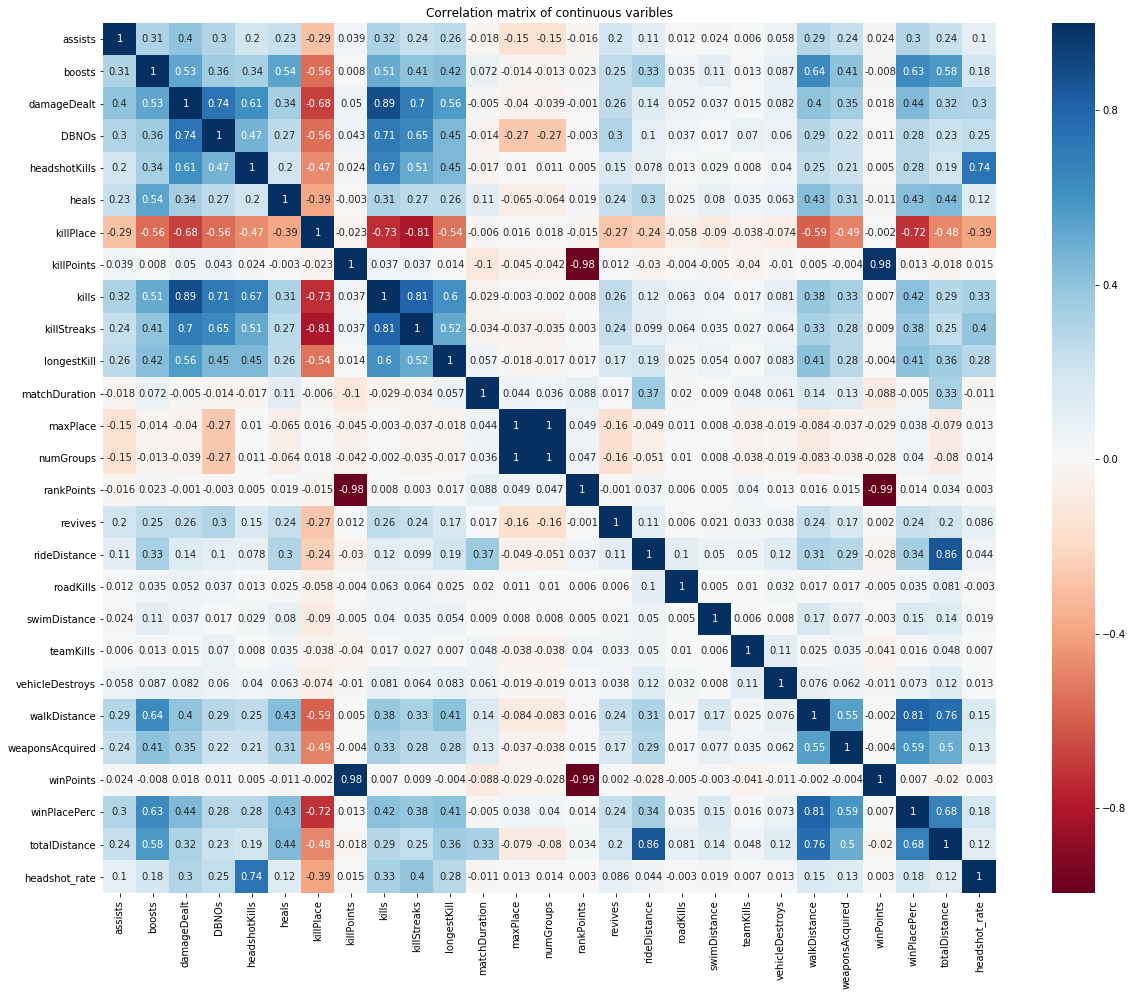

In [13]:
# correlation matrix
corr_matrix = ndf.corr()
corr_matrix= corr_matrix.round(decimals=3)
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix,annot=True, cmap="RdBu")
plt.title("Correlation matrix of continuous varibles")

Text(0.5, 0, 'predictors')

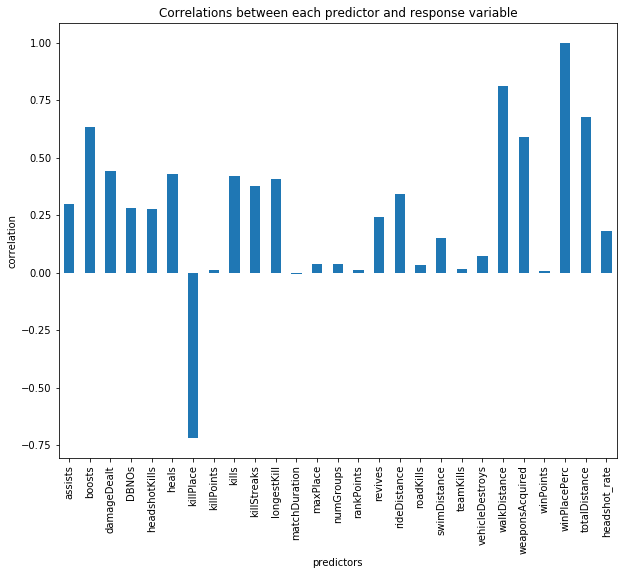

In [14]:
# bar graph correlations
corr_matrix["winPlacePerc"][:"headshot_rate"].plot(kind="bar",figsize=(10,8))
plt.title("Correlations between each predictor and response variable")
plt.ylabel("correlation")
plt.xlabel("predictors")

In [15]:
# get dummies for the different match types
dummies = pd.get_dummies(ndf["matchType"])
dummies= dummies.loc[:,"duo":]
ndf = pd.merge(dummies,ndf,left_index=True,right_index=True).drop(columns = "matchType")


In [16]:
# preprocessing and data normalization
# ml models are sensitive to outliers so we normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

ndf.drop(columns=['winPlacePerc'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(ndf, y, test_size=0.3, random_state=50)



minmax_scaler = MinMaxScaler()
X_train_n = minmax_scaler.fit_transform(X_train)
X_test_n = minmax_scaler.fit_transform(X_test)
y_train = np.array(y_train)


In [17]:
ndf.columns

Index(['duo', 'duo-fpp', 'flarefpp', 'flaretpp', 'normal-duo',
       'normal-duo-fpp', 'normal-solo', 'normal-solo-fpp', 'normal-squad',
       'normal-squad-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp', 'assists',
       'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
       'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPoints', 'totalDistance',
       'headshot_rate'],
      dtype='object')

In [18]:
# linear regression with k fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5,random_state=50,shuffle=True)

X = X_train_n
y = y_train

for train_index, test_index in tqdm(kf.split(X)):
    X_train_, X_valid = X[train_index,], X[test_index,]
    y_train_, y_valid = y[train_index], y[test_index]
    lm = LinearRegression()

    lm.fit(X_train_,y_train_)
    y_pred = lm.predict(X_valid)
    mae = mean_absolute_error(y_pred=y_pred,y_true = y_valid)
    score = cross_val_score(lm, y_valid.reshape(-1,1),y_pred.reshape(-1,1), cv=kf)
    score = np.mean(score)
    print("Accuracy score: {:.03f}, mean absolute error: {:.03f} ".format(score, mae))
    

1it [00:09,  9.88s/it]

Accuracy score: 0.844, mean absolute error: 0.089 


2it [00:18,  9.49s/it]

Accuracy score: 0.843, mean absolute error: 0.089 


3it [00:24,  8.53s/it]

Accuracy score: 0.844, mean absolute error: 0.089 


4it [00:32,  8.33s/it]

Accuracy score: 0.843, mean absolute error: 0.089 


5it [00:40,  8.21s/it]

Accuracy score: 0.843, mean absolute error: 0.089 


- not bad score above
- Going to try ridge regression because linear maybe be overfitting

In [19]:
from sklearn.linear_model import Ridge

alpha_param = 10**(-np.arange(11,dtype="float"))

for alpha in tqdm(alpha_param):
    mae_array = []
    for train_index, test_index in kf.split(X):
        X_train_, X_valid = X[train_index,], X[test_index,]
        y_train_, y_valid = y[train_index], y[test_index]
        ridge_lm = Ridge(alpha=alpha)
        ridge_lm.fit(X_train_,y_train_)
        y_pred = ridge_lm.predict(X_valid)
        mae = mean_absolute_error(y_pred=y_pred,y_true = y_valid)
        mae_array.append(mae)
    print("average of mean absolute error for alpha = {} is {}".format(alpha,np.mean(mae_array)))

  9%|▉         | 1/11 [00:12<02:09, 12.98s/it]

average of mean absolute error for alpha = 1.0 is 0.08881957583570026


 18%|█▊        | 2/11 [00:26<01:57, 13.02s/it]

average of mean absolute error for alpha = 0.1 is 0.08881627643581141


 27%|██▋       | 3/11 [00:38<01:43, 12.96s/it]

average of mean absolute error for alpha = 0.01 is 0.08881595026063349


 36%|███▋      | 4/11 [00:51<01:30, 12.99s/it]

average of mean absolute error for alpha = 0.001 is 0.08881591766703892


 45%|████▌     | 5/11 [01:04<01:17, 12.95s/it]

average of mean absolute error for alpha = 0.0001 is 0.08881591440781175


 55%|█████▍    | 6/11 [01:17<01:04, 12.99s/it]

average of mean absolute error for alpha = 1e-05 is 0.0888159140818903


 64%|██████▎   | 7/11 [01:30<00:51, 12.99s/it]

average of mean absolute error for alpha = 1e-06 is 0.08881591404929812


 73%|███████▎  | 8/11 [01:43<00:38, 12.95s/it]

average of mean absolute error for alpha = 1e-07 is 0.08881591404603892


 82%|████████▏ | 9/11 [01:56<00:25, 12.93s/it]

average of mean absolute error for alpha = 1e-08 is 0.08881591404571286


 91%|█████████ | 10/11 [02:09<00:12, 12.97s/it]

average of mean absolute error for alpha = 1e-09 is 0.08881591404567855


100%|██████████| 11/11 [02:22<00:00, 12.96s/it]

average of mean absolute error for alpha = 1e-10 is 0.08881591404563768


In [20]:
# Try ML

from torch.autograd import Variable 
from torch.nn import functional as F

import torch #ml library - no dedicated NVIDIA card so using processor -RIP

# Format data
X_train_tensor = torch.from_numpy(X_train_n)
y_train_tensor = torch.from_numpy(y_train)


X_train_v = Variable(X_train_tensor)
y_train_v = Variable(y_train_tensor)


X_train_v =X_train_v.float()
y_train_v = y_train_v.float()

y_train_v= y_train_v.reshape(y_train_v.shape[0],-1)

In [21]:
X_train_v.shape

torch.Size([3111494, 40])

In [22]:

class Net(torch.nn.Module): 
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__() 
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
 
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = self.predict(x)
        return x

In [23]:
net= Net(40,50,1)

optimizer = torch.optim.SGD(net.parameters(), lr=0.005) 
loss_function = torch.nn.MSELoss()


# range can be increased for better results, currently the linear models are outperforming the machine learning models
for t in tqdm(range(30)):
    prediction = net(X_train_v) 
    loss = loss_function(prediction, y_train_v) 
    print ("loss of learning time {} is {}".format(t,loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/30 [00:00<?, ?it/s]

loss of learning time 0 is 0.45018666982650757


  3%|▎         | 1/30 [00:04<02:18,  4.76s/it]

loss of learning time 1 is 0.3596040904521942


  7%|▋         | 2/30 [00:08<02:05,  4.49s/it]

loss of learning time 2 is 0.2919181287288666


 10%|█         | 3/30 [00:12<01:53,  4.22s/it]

loss of learning time 3 is 0.24136540293693542


 13%|█▎        | 4/30 [00:15<01:44,  4.04s/it]

loss of learning time 4 is 0.2035921812057495


 17%|█▋        | 5/30 [00:19<01:37,  3.91s/it]

loss of learning time 5 is 0.17537501454353333


 20%|██        | 6/30 [00:23<01:32,  3.84s/it]

loss of learning time 6 is 0.15429475903511047


 23%|██▎       | 7/30 [00:26<01:26,  3.76s/it]

loss of learning time 7 is 0.13854631781578064


 27%|██▋       | 8/30 [00:30<01:21,  3.72s/it]

loss of learning time 8 is 0.12677989900112152


 30%|███       | 9/30 [00:33<01:17,  3.68s/it]

loss of learning time 9 is 0.11798892915248871


 33%|███▎      | 10/30 [00:37<01:11,  3.57s/it]

loss of learning time 10 is 0.11142042279243469


 37%|███▋      | 11/30 [00:40<01:04,  3.38s/it]

loss of learning time 11 is 0.10651231557130814


 40%|████      | 12/30 [00:43<00:58,  3.25s/it]

loss of learning time 12 is 0.10284410417079926


 43%|████▎     | 13/30 [00:46<00:57,  3.38s/it]

loss of learning time 13 is 0.10010267794132233


 47%|████▋     | 14/30 [00:50<00:55,  3.45s/it]

loss of learning time 14 is 0.09805326163768768


 50%|█████     | 15/30 [00:54<00:52,  3.52s/it]

loss of learning time 15 is 0.09652077406644821


 53%|█████▎    | 16/30 [00:57<00:50,  3.58s/it]

loss of learning time 16 is 0.09537441283464432


 57%|█████▋    | 17/30 [01:01<00:46,  3.60s/it]

loss of learning time 17 is 0.09451649338006973


 60%|██████    | 18/30 [01:04<00:43,  3.60s/it]

loss of learning time 18 is 0.09387403726577759


 63%|██████▎   | 19/30 [01:08<00:39,  3.55s/it]

loss of learning time 19 is 0.093392513692379


 67%|██████▋   | 20/30 [01:11<00:35,  3.54s/it]

loss of learning time 20 is 0.09303120523691177


 70%|███████   | 21/30 [01:15<00:32,  3.61s/it]

loss of learning time 21 is 0.09275967627763748


 73%|███████▎  | 22/30 [01:19<00:28,  3.59s/it]

loss of learning time 22 is 0.0925552174448967


 77%|███████▋  | 23/30 [01:22<00:25,  3.60s/it]

loss of learning time 23 is 0.09240085631608963


 80%|████████  | 24/30 [01:26<00:21,  3.66s/it]

loss of learning time 24 is 0.09228391200304031


 83%|████████▎ | 25/30 [01:30<00:18,  3.61s/it]

loss of learning time 25 is 0.09219490736722946


 87%|████████▋ | 26/30 [01:33<00:14,  3.64s/it]

loss of learning time 26 is 0.09212678670883179


 90%|█████████ | 27/30 [01:37<00:10,  3.65s/it]

loss of learning time 27 is 0.09207426011562347


 93%|█████████▎| 28/30 [01:41<00:07,  3.59s/it]

loss of learning time 28 is 0.09203337132930756


 97%|█████████▋| 29/30 [01:44<00:03,  3.61s/it]

loss of learning time 29 is 0.09200118482112885


100%|██████████| 30/30 [01:48<00:00,  3.67s/it]


In [24]:
from sklearn.ensemble import RandomForestRegressor
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
from fastai.imports import *
print(m1.feature_importances_, df.shape)
def rf_feat_importance(m, df):
    return pd.DataFrame({'features':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

fi = rf_feat_importance(m1, ndf); fi[:10]

[3.34461086e-04 7.94334830e-04 2.46054899e-06 8.47040191e-06
 8.03351931e-07 2.63766546e-04 1.88913031e-06 2.80342679e-05
 2.55418852e-06 5.34922948e-04 4.71313488e-04 1.80278091e-03
 1.48757038e-03 1.23251827e-03 4.07815544e-03 7.02223233e-02
 1.75508551e-02 4.62689657e-03 1.08308577e-03 4.66389343e-02
 1.97386332e-01 2.53680270e-03 1.11117745e-02 5.87741246e-03
 2.06153337e-02 1.75506167e-02 9.14475832e-03 1.12514813e-02
 4.22307184e-03 4.15393766e-03 1.25549068e-02 5.14133322e-05
 2.42360238e-03 1.95405183e-04 3.53115639e-05 2.56142260e-01
 3.91111821e-02 3.15400169e-03 2.47839610e-01 3.47465494e-03] (4444992, 32)


,features,importance
35,walkDistance,0.256142
38,totalDistance,0.247840
20,killPlace,0.197386
15,boosts,0.070222
19,heals,0.046639
36,weaponsAcquired,0.039111
24,longestKill,0.020615
16,damageDealt,0.017551
25,matchDuration,0.017551
30,rideDistance,0.012555


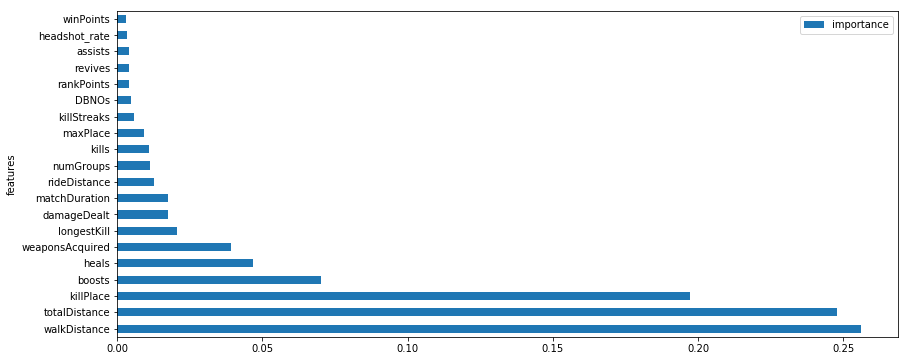

In [26]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('features', 'importance', figsize=(14,6), kind = 'barh')
plot1